# Introduction

https://www.kaggle.com/datasets/saurabhshahane/in-hospital-mortality-prediction?resource=download

## Dependencies

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers, utils, backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

## Data Pre-Processing

I will replace the null values with -1. This is to allow the network to still make calculations with those values given the algorith used in learning (back-propagation) while also allowing the network to learn there is a possible association between those missing values. -1 is not a meaningful or actual value in the dataset prior to imputation.

In [2]:
#read in data from uploaded file
train_recode = pd.read_csv("train_recode.csv")
test_recode = pd.read_csv("test_recode.csv")
#drop repeated columns
# Age, Gender, ICUType, and height_cleaned are all demographic unchanging variables, due to the way this was initially transposed these were
#duplicated and thus are removed here. MechVent was removed because MechVent_cleaned was used instead.
train_recode_rem = train_recode.drop(["Age_2", "Age_3", "Age_4", "Gender_2", "Gender_3", "Gender_4", "ICUType_2", "ICUType_3", "ICUType_4", "MechVent_1", "MechVent_2", "MechVent_3", "MechVent_4", "height_cleaned_2", "height_cleaned_3", "height_cleaned_4"], axis = 1)
test_recode_rem = test_recode.drop(["Age_2", "Age_3", "Age_4", "Gender_2", "Gender_3", "Gender_4", "ICUType_2", "ICUType_3", "ICUType_4", "MechVent_1", "MechVent_2", "MechVent_3", "MechVent_4", "height_cleaned_2", "height_cleaned_3", "height_cleaned_4"], axis = 1)
#This replaces NA values with -1
train_rem_neg1 = train_recode_rem.fillna(-1)
test_rem_neg1 = test_recode_rem.fillna(-1)


In [3]:
train_x = train_rem_neg1.drop(["subjid", "In.hospital_death"], axis = 1)
train_y = train_rem_neg1["In.hospital_death"]

In [4]:
# define metrics
def Recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def Precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def F1(y_true, y_pred):
    precision = Precision(y_true, y_pred)
    recall = Recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Model Build 1

In [5]:
n_features1 = train_x.shape[1] #returns the width of the dataframe, or the number of input features for the model

In [6]:
n_features1

153

In [7]:
model1 = models.Sequential(name="Model1", layers=[
    ### hidden layer 1
    layers.Dense(name="h1",
                 input_dim=n_features1,
                 units=n_features1, 
                 activation='relu',
                 kernel_initializer = "TruncatedNormal"),
    layers.Dropout(name="drop1", rate=0.2, seed=749),
    ### layer output
    layers.Dense(name="output", units=1, activation='sigmoid')
])
model1.summary()

Model: "Model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 153)               23562     
                                                                 
 drop1 (Dropout)             (None, 153)               0         
                                                                 
 output (Dense)              (None, 1)                 154       
                                                                 
Total params: 23,716
Trainable params: 23,716
Non-trainable params: 0
_________________________________________________________________


In [8]:
# compile the neural network
random.seed(749)
model1.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy',F1])

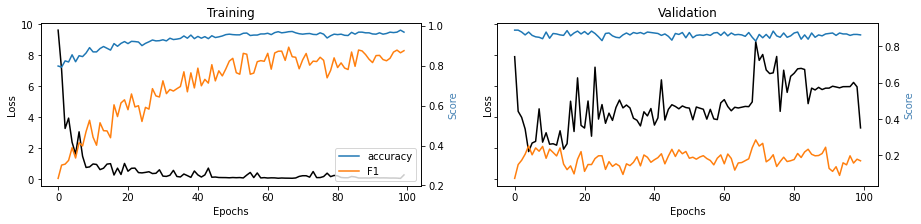

In [9]:
# train/validation
training1 = model1.fit(x=train_x, y=train_y, batch_size=32, epochs=100, shuffle=True, verbose=0, validation_split=0.3)

# plot
metrics = [k for k in training1.history.keys() if ("loss" not in k) and ("val" not in k)]    
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
       
## training    
ax[0].set(title="Training")    
ax11 = ax[0].twinx()    
ax[0].plot(training1.history['loss'], color='black')
ax[0].set_xlabel('Epochs')    
ax[0].set_ylabel('Loss', color='black')    
for metric in metrics:        
    ax11.plot(training1.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')    
ax11.legend()
        
## validation    
ax[1].set(title="Validation")    
ax22 = ax[1].twinx()    
ax[1].plot(training1.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')    
ax[1].set_ylabel('Loss', color='black')    
for metric in metrics:          
    ax22.plot(training1.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")    
plt.show()

## Model Build 2

In [10]:
n_features2 = train_x.shape[1] #returns the width of the dataframe, or the number of input features for the model

In [11]:
model2 = models.Sequential(name="Model2", layers=[
    ### hidden layer 1
    layers.Dense(name="h1", input_dim=n_features2,
                 units=n_features2, 
                 activation='relu',
                 kernel_initializer = "TruncatedNormal"),
    layers.Dropout(name="drop1", rate=0.2, seed = 749),
     ### hidden layer 2
    layers.Dense(name="h2",
                 input_dim=n_features2,
                 units=n_features2, 
                 activation='relu',
                 kernel_initializer = "TruncatedNormal"),
    layers.Dropout(name="drop2", rate=0.2, seed = 749),
    layers.Dense(name="output", units=1, activation='sigmoid')
])
model2.summary()

Model: "Model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 153)               23562     
                                                                 
 drop1 (Dropout)             (None, 153)               0         
                                                                 
 h2 (Dense)                  (None, 153)               23562     
                                                                 
 drop2 (Dropout)             (None, 153)               0         
                                                                 
 output (Dense)              (None, 1)                 154       
                                                                 
Total params: 47,278
Trainable params: 47,278
Non-trainable params: 0
_________________________________________________________________


In [12]:
# compile the neural network
random.seed(749)
model2.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy',F1])

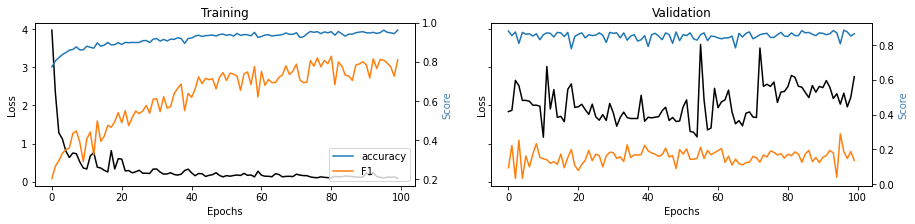

In [13]:
# train/validation
training2 = model2.fit(x=train_x, y=train_y, batch_size=32, epochs=100, shuffle=True, verbose=0, validation_split=0.3)

# plot
metrics = [k for k in training1.history.keys() if ("loss" not in k) and ("val" not in k)]    
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
       
## training    
ax[0].set(title="Training")    
ax11 = ax[0].twinx()    
ax[0].plot(training2.history['loss'], color='black')
ax[0].set_xlabel('Epochs')    
ax[0].set_ylabel('Loss', color='black')    
for metric in metrics:        
    ax11.plot(training2.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')    
ax11.legend()
        
## validation    
ax[1].set(title="Validation")    
ax22 = ax[1].twinx()    
ax[1].plot(training2.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')    
ax[1].set_ylabel('Loss', color='black')    
for metric in metrics:          
    ax22.plot(training2.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")    
plt.show()

## Model Build 3

In [14]:
n_features3 = train_x.shape[1] #returns the width of the dataframe, or the number of input features for the model

In [15]:
model3 = models.Sequential(name="Model3", layers=[
    ### hidden layer 1
    layers.Dense(name="h1",
                 input_dim=n_features3,
                 units=n_features3, 
                 activation='relu',
                 kernel_initializer = "TruncatedNormal"),
    layers.Dropout(name="drop1", rate=0.2, seed = 749),
     ### hidden layer 2
    layers.Dense(name="h2",
                 units=n_features3, 
                 activation='relu',
                 kernel_initializer = "TruncatedNormal"),
    layers.Dropout(name="drop2", rate=0.2, seed = 749),
     ### hidden layer 3
    layers.Dense(name="h3",
                 units=n_features3,
                 activation='relu',
                 kernel_initializer = "TruncatedNormal"),
    layers.Dropout(name="drop3", rate=0.2, seed = 749),
    layers.Dense(name="output", units=1, activation='sigmoid')
])
model3.summary()

Model: "Model3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 153)               23562     
                                                                 
 drop1 (Dropout)             (None, 153)               0         
                                                                 
 h2 (Dense)                  (None, 153)               23562     
                                                                 
 drop2 (Dropout)             (None, 153)               0         
                                                                 
 h3 (Dense)                  (None, 153)               23562     
                                                                 
 drop3 (Dropout)             (None, 153)               0         
                                                                 
 output (Dense)              (None, 1)                 154  

In [16]:
# compile the neural network
random.seed(749)
model3.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy',F1])

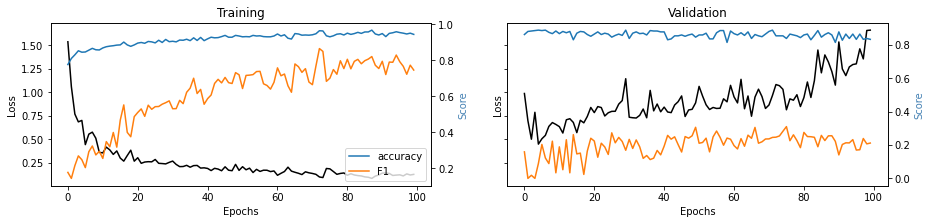

In [17]:
# train/validation
training3 = model3.fit(x=train_x, y=train_y, batch_size=32, epochs=100, shuffle=True, verbose=0, validation_split=0.3)

# plot
metrics = [k for k in training3.history.keys() if ("loss" not in k) and ("val" not in k)]    
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
       
## training    
ax[0].set(title="Training")    
ax11 = ax[0].twinx()    
ax[0].plot(training3.history['loss'], color='black')
ax[0].set_xlabel('Epochs')    
ax[0].set_ylabel('Loss', color='black')    
for metric in metrics:        
    ax11.plot(training3.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')    
ax11.legend()
        
## validation    
ax[1].set(title="Validation")    
ax22 = ax[1].twinx()    
ax[1].plot(training3.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')    
ax[1].set_ylabel('Loss', color='black')    
for metric in metrics:          
    ax22.plot(training3.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")    
plt.show()

## Evaluation

In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc, precision_recall_curve
import seaborn as sns

In [19]:
test_x = test_rem_neg1.drop(["subjid", "In.hospital_death"], axis = 1)
test_y = test_rem_neg1["In.hospital_death"]

In [20]:
total_prev_of_outcome = (train_y.sum() + test_y.sum()) / (train_y.shape[0] + test_y.shape[0])
total_prev_of_outcome

0.12947658402203857

In [21]:
test_prev_of_outcome = test_y.sum() / test_y.shape[0]
test_prev_of_outcome

0.12293577981651377

### Model 1

In [22]:
predictions_NN_prob1 = model1.predict(test_x)
predictions_NN_prob1 = predictions_NN_prob1[:,0]
# use 0.13 as threshold because that is the approximate prevalence in the data of death
predictions_NN_01 = np.where(predictions_NN_prob1 > 0.13, 1, 0) #Turn probability to 0-1 binary output

18/18 [==============================] - 0s 2ms/step


In [23]:
acc_NN1 = accuracy_score(test_y, predictions_NN_01)
print('Overall accuracy of Neural Network model:', acc_NN1)

Overall accuracy of Neural Network model: 0.7834862385321101


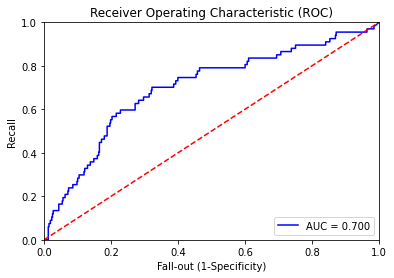

In [24]:
false_positive_rate1, recall1, thresholds1 = roc_curve(test_y, predictions_NN_prob1)
roc_auc1 = auc(false_positive_rate1, recall1)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate1, recall1, 'b', label = 'AUC = %0.3f' %roc_auc1)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

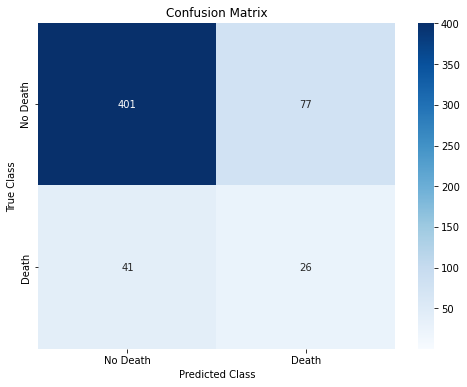

In [25]:
cm1 = confusion_matrix(test_y, predictions_NN_01)
labels = ['No Death', 'Death']
plt.figure(figsize=(8,6))
sns.heatmap(cm1,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

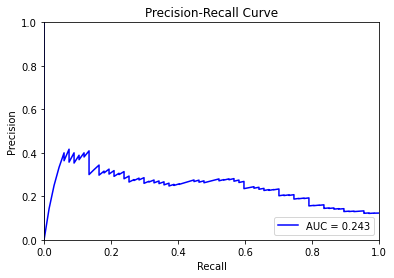

In [26]:
precision1, recall1, thresholds1 = precision_recall_curve(test_y, predictions_NN_prob1)
prc_auc1 = auc(recall1, precision1)
plt.figure()
plt.title('Precision-Recall Curve')
plt.plot(recall1, precision1, 'b', label = 'AUC = %0.3f' %prc_auc1)
plt.legend(loc='lower right')
# plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

### Model 2

In [27]:
predictions_NN_prob2 = model2.predict(test_x)
predictions_NN_prob2 = predictions_NN_prob2[:,0]
# use 0.13 as threshold because that is the approximate prevalence in the data of death
predictions_NN_02 = np.where(predictions_NN_prob2 > 0.13, 1, 0) #Turn probability to 0-1 binary output

18/18 [==============================] - 0s 2ms/step


In [28]:
acc_NN2 = accuracy_score(test_y, predictions_NN_02)
print('Overall accuracy of Neural Network model:', acc_NN2)

Overall accuracy of Neural Network model: 0.8165137614678899


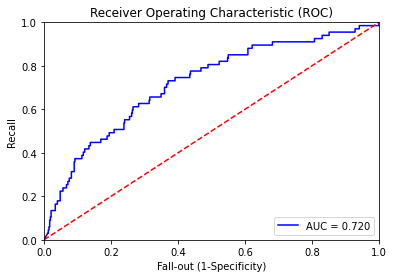

In [29]:
false_positive_rate2, recall2, thresholds2 = roc_curve(test_y, predictions_NN_prob2)
roc_auc2 = auc(false_positive_rate2, recall2)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate2, recall2, 'b', label = 'AUC = %0.3f' %roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

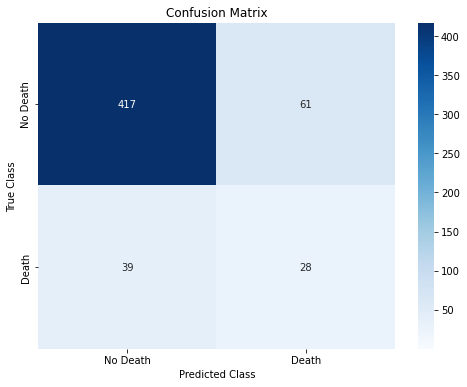

In [30]:
cm2 = confusion_matrix(test_y, predictions_NN_02)
labels = ['No Death', 'Death']
plt.figure(figsize=(8,6))
sns.heatmap(cm2,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

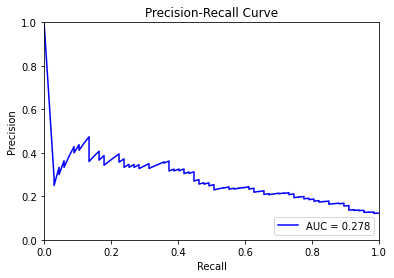

In [31]:
precision2, recall2, thresholds2 = precision_recall_curve(test_y, predictions_NN_prob2)
prc_auc2 = auc(recall2, precision2)
plt.figure()
plt.title('Precision-Recall Curve')
plt.plot(recall2, precision2, 'b', label = 'AUC = %0.3f' %prc_auc2)
plt.legend(loc='lower right')
# plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

### Model 3

In [32]:
predictions_NN_prob3 = model3.predict(test_x)
predictions_NN_prob3 = predictions_NN_prob3[:,0]
# use 0.13 as threshold because that is the approximate prevalence in the data of death
predictions_NN_03 = np.where(predictions_NN_prob3 > 0.13, 1, 0) #Turn probability to 0-1 binary output

18/18 [==============================] - 0s 2ms/step


In [33]:
acc_NN3 = accuracy_score(test_y, predictions_NN_03)
print('Overall accuracy of Neural Network model:', acc_NN3)

Overall accuracy of Neural Network model: 0.781651376146789


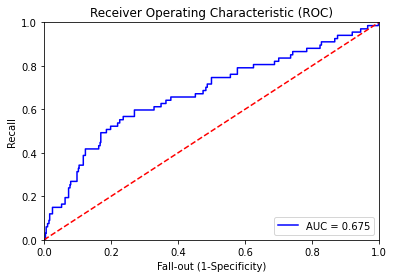

In [34]:
false_positive_rate3, recall3, thresholds3 = roc_curve(test_y, predictions_NN_prob3)
roc_auc3 = auc(false_positive_rate3, recall3)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate3, recall3, 'b', label = 'AUC = %0.3f' %roc_auc3)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

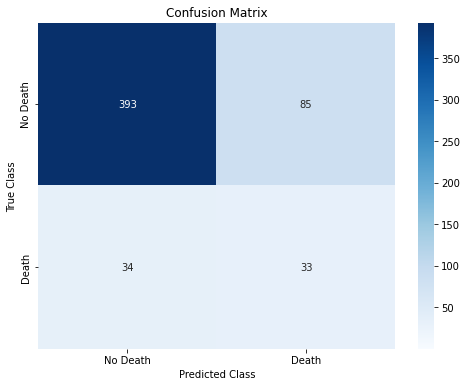

In [35]:
cm3 = confusion_matrix(test_y, predictions_NN_03)
labels = ['No Death', 'Death']
plt.figure(figsize=(8,6))
sns.heatmap(cm3,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

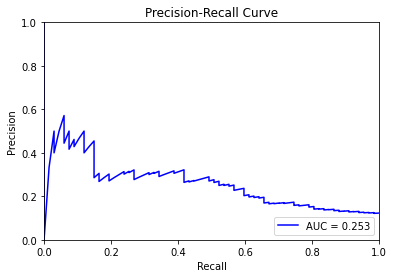

In [36]:
precision3, recall3, thresholds3 = precision_recall_curve(test_y, predictions_NN_prob3)
prc_auc3 = auc(recall3, precision3)
plt.figure()
plt.title('Precision-Recall Curve')
plt.plot(recall3, precision3, 'b', label = 'AUC = %0.3f' %prc_auc3)
plt.legend(loc='lower right')
# plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()